In [1]:
import pandas as pd
import sys
sys.path.insert(0, "../..")
from utils.simulation import BacktestSimulation, TradingAction
from strategies.covered_call_strategy import create_covered_call_strategy
from datetime import datetime, timedelta

ticker = "MSTR"
strike_factor = 1.06
time = 15 / 365

tickers = [ticker]
start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)
initial_cash = 100000

Loading market data...


/Users/ryan/Desktop/quantitative-trading-models/strategies/covered_call/../../utils/simulation.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)


Running simulation from 2024-01-02 to 2024-12-30
Total trading days: 251
Performance Stats

=== Performance Summary ===
Initial Value: $100,000.00
Final Value: $185,971.92
Total Return: 85.97%
Sharpe Ratio: 1.29
Max Drawdown: 30.02%
Annualized Volatility: 65.03%

Total transactions: 84

Transaction History:
         date          action ticker  shares       price          total  contracts      strike  premium_per_share  total_premium expiration  current_price  shares_sold
0  2024-01-02       BUY_STOCK   MSTR  1459.0   68.514999   99963.384109        NaN         NaN                NaN            NaN        NaT            NaN          NaN
1  2024-01-02       SELL_CALL   MSTR     NaN         NaN            NaN       14.0   72.625899           2.052255    2873.157176 2024-01-17            NaN          NaN
2  2024-01-03       BUY_STOCK   MSTR    46.0   63.105999    2902.875954        NaN         NaN                NaN            NaN        NaT            NaN          NaN
3  2024-01-17      

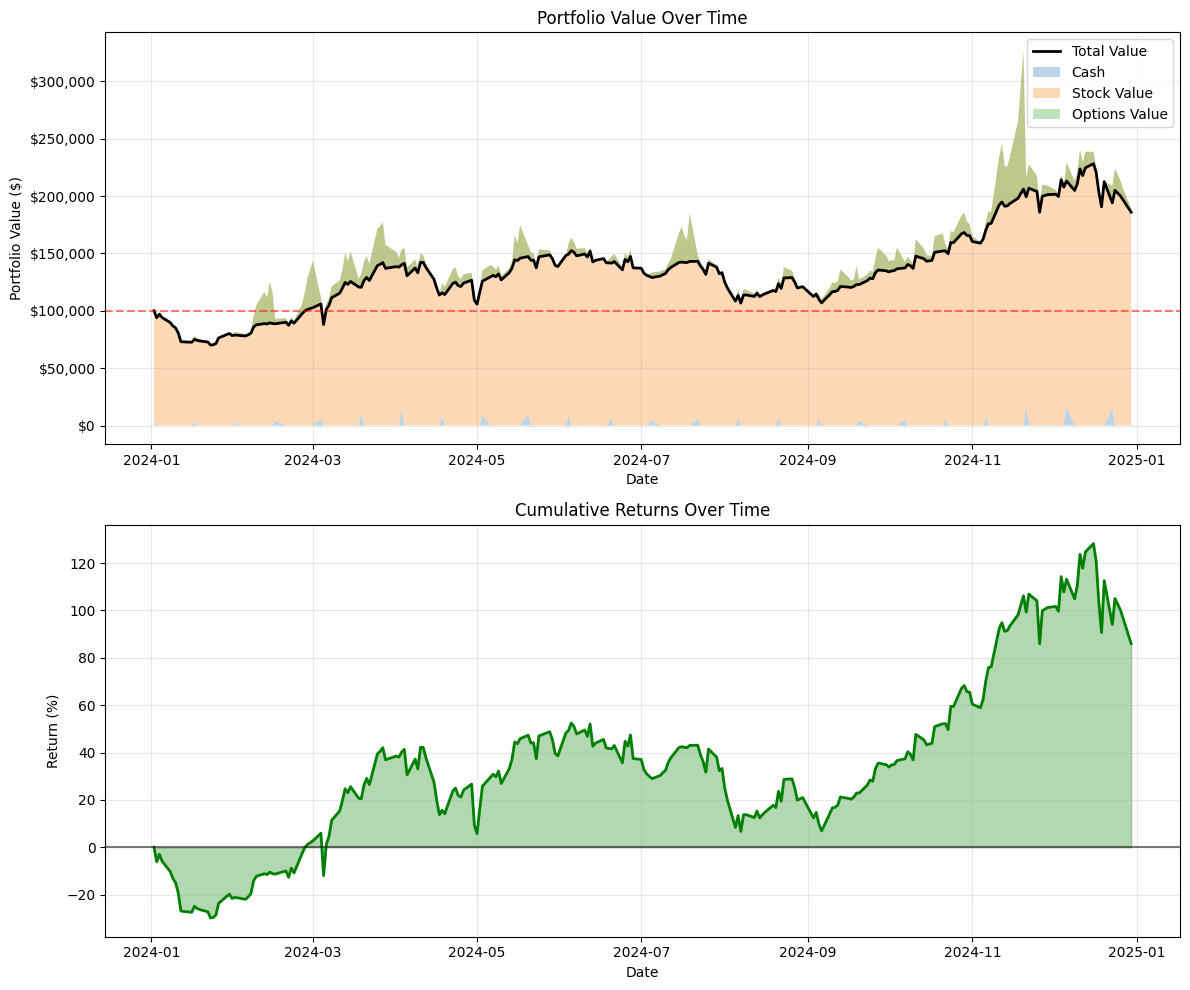

In [2]:
covered_call_strategy = create_covered_call_strategy(ticker=ticker, 
                                                     strike_factor=strike_factor, 
                                                     time_to_expiration=time)

sim = BacktestSimulation(
    tickers=tickers,
    start_date=start,
    end_date=end,
    initial_cash=initial_cash,
    strategy_callback=covered_call_strategy
)

sim.run()

print("Performance Stats")
sim.print_performance_stats()

transactions = sim.get_transactions()
print(f"\nTotal transactions: {len(transactions)}")
print("\nTransaction History:")
print(transactions.to_string())
sim.plot_portfolio_history()

Loading market data...
Running simulation from 2024-01-02 to 2024-12-30
Total trading days: 251
Performance Stats

=== Performance Summary ===
Initial Value: $100,000.00
Final Value: $442,055.24
Total Return: 342.06%
Sharpe Ratio: 1.90
Max Drawdown: 46.41%
Annualized Volatility: 110.30%

Total transactions: 1

Transaction History:
        date     action ticker  shares      price         total
0 2024-01-02  BUY_STOCK   MSTR    1459  68.514999  99963.384109


/Users/ryan/Desktop/quantitative-trading-models/strategies/covered_call/../../utils/simulation.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)


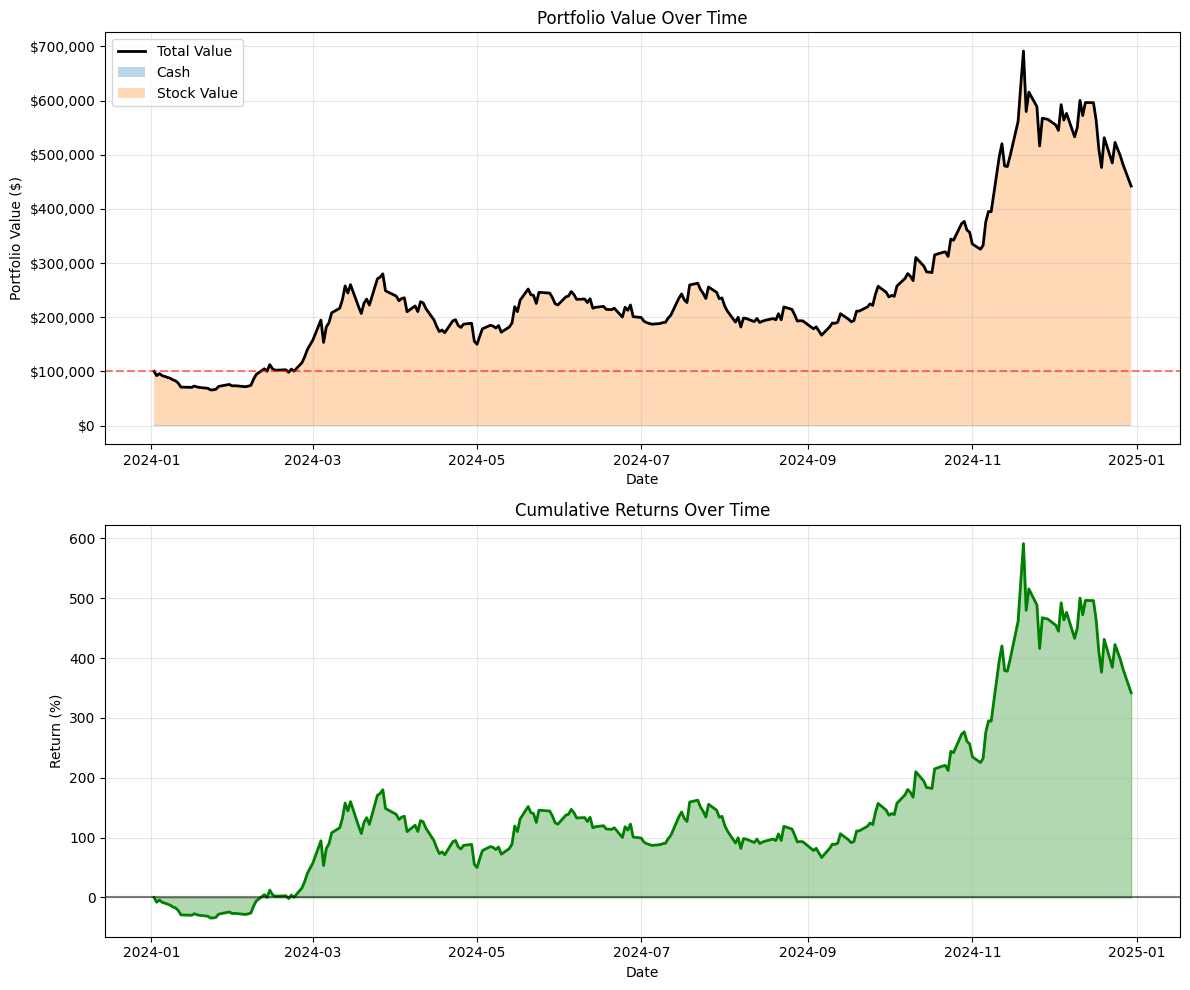

In [3]:
def buy_and_hold(date, portfolio, market_data, actions):
    current_price = market_data['prices'][ticker]

    max_shares = int(portfolio.cash / current_price)
    if max_shares > 0:
        actions.buy_stock(portfolio, ticker, max_shares, current_price)


sim = BacktestSimulation(
    tickers=tickers,
    start_date=start,
    end_date=end,
    initial_cash=initial_cash,
    strategy_callback=buy_and_hold
)

sim.run()

print("Performance Stats")
sim.print_performance_stats()

transactions = sim.get_transactions()
print(f"\nTotal transactions: {len(transactions)}")
print("\nTransaction History:")
print(transactions.to_string())
sim.plot_portfolio_history()